# Multidimensional Ideal-Point Voting Simulation

This notebook generates a voting instance where voters and candidates are points in a $d$-dimensional preference space. Voters prefer candidates that are closer under a chosen metric distance.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

## Model

- Each voter $i$ has an ideal point $v_i \in \mathbb{R}^d$.
- Each candidate $j$ has a position $c_j \in \mathbb{R}^d$.
- Distance: $\operatorname{dist}(v_i, c_j) = \|v_i - c_j\|_p$.
- Utility: $u_{ij} = -\operatorname{dist}(v_i, c_j)$.
- Ballot rule can be plurality (nearest candidate) or probabilistic Borda from pairwise wins.

In [62]:
def generate_ideal_points(n_points, d, rng, distribution="normal", scale=1.0):
    if distribution == "normal":
        return rng.normal(loc=0.0, scale=scale, size=(n_points, d))
    if distribution == "uniform":
        return rng.uniform(low=-scale, high=scale, size=(n_points, d))
    raise ValueError("distribution must be 'normal' or 'uniform'")


def lp_distance_matrix(voters, candidates, p=2):
    # Shape: (n_voters, n_candidates, d)
    diff = voters[:, None, :] - candidates[None, :, :]
    if p == 1:
        return np.abs(diff).sum(axis=2)
    if p == 2:
        return np.sqrt((diff ** 2).sum(axis=2))
    return (np.abs(diff) ** p).sum(axis=2) ** (1.0 / p)


def simulate_plurality_from_distance(voters, candidates, p=2):
    distances = lp_distance_matrix(voters, candidates, p=p)
    utilities = -distances

    # Each voter chooses the closest candidate.
    chosen = distances.argmin(axis=1)
    vote_counts = np.bincount(chosen, minlength=candidates.shape[0])
    vote_shares = vote_counts / vote_counts.sum()
    winner = int(vote_counts.argmax())

    return {
        "distances": distances,
        "utilities": utilities,
        "chosen": chosen,
        "vote_counts": vote_counts,
        "vote_shares": vote_shares,
        "winner": winner,
    }


def simulate_borda_from_distance(voters, candidates, p=2, beta=1.0):
    distances = lp_distance_matrix(voters, candidates, p=p)
    utilities = -distances

    # Pairwise win probabilities per voter:
    # P(x beats y) = sigmoid(beta * (u_x - u_y)).
    u_x = utilities[:, :, None]
    u_y = utilities[:, None, :]
    pairwise_probs = 1.0 / (1.0 + np.exp(-beta * (u_x - u_y)))

    # Borda score for candidate x is expected pairwise wins summed over y.
    voter_borda = pairwise_probs.sum(axis=2)
    borda_scores = voter_borda.mean(axis=0)
    borda_shares = borda_scores / borda_scores.sum()
    winner = int(borda_scores.argmax())

    return {
        "distances": distances,
        "utilities": utilities,
        "pairwise_probs": pairwise_probs,
        "borda_scores": borda_scores,
        "borda_shares": borda_shares,
        "winner": winner,
    }

In [63]:
# Parameters
n_voters = 1000
n_candidates = 6
d = 2
p_metric = 2
aggregation_rule = "borda"  # "plurality" or "borda"
beta = 1.0

voters = generate_ideal_points(n_voters, d, rng, distribution="normal", scale=1.0)
candidates = generate_ideal_points(n_candidates, d, rng, distribution="normal", scale=1.2)

if aggregation_rule == "plurality":
    result = simulate_plurality_from_distance(voters, candidates, p=p_metric)
elif aggregation_rule == "borda":
    result = simulate_borda_from_distance(voters, candidates, p=p_metric, beta=beta)
else:
    raise ValueError("aggregation_rule must be 'plurality' or 'borda'")

In [64]:
if aggregation_rule == "plurality":
    score_col = "votes"
    share_col = "vote_share"
    scores = result["vote_counts"]
    shares = result["vote_shares"]
else:
    score_col = "borda_score"
    share_col = "borda_share"
    scores = result["borda_scores"]
    shares = result["borda_shares"]

summary = pd.DataFrame({
    "candidate": np.arange(n_candidates),
    score_col: scores,
    share_col: shares,
})
summary = summary.sort_values(score_col, ascending=False).reset_index(drop=True)

avg_utility = result["utilities"].mean(axis=0)
utility_winner = int(avg_utility.argmax())
utility_summary = pd.DataFrame({
    "candidate": np.arange(n_candidates),
    "avg_utility": avg_utility,
}).sort_values("avg_utility", ascending=False).reset_index(drop=True)

from IPython.display import display

print(f"{aggregation_rule.capitalize()} winner: candidate {result['winner']}")
print(f"Average-utility winner: candidate {utility_winner}")
display(summary)
print("\nAverage utility per candidate:")
display(utility_summary)

if aggregation_rule == "borda":
    pairwise_mean = result["pairwise_probs"].mean(axis=0)
    if n_candidates > 1:
        win_rates = (pairwise_mean.sum(axis=1) - 0.5) / (n_candidates - 1)
    else:
        win_rates = np.array([1.0])

    win_rate_table = pd.DataFrame({
        "candidate": np.arange(n_candidates),
        "win_rate": win_rates,
    }).sort_values("win_rate", ascending=False).reset_index(drop=True)

    print("\nPairwise win rates per candidate (average vs other candidates):")
    display(win_rate_table)

Borda winner: candidate 1
Average-utility winner: candidate 1


,candidate,borda_score,borda_share
0,1,3.711608,0.206200
1,0,3.542596,0.196811
2,3,3.217327,0.178740
3,4,2.916031,0.162002
4,2,2.548289,0.141572
5,5,2.064150,0.114675



Average utility per candidate:


,candidate,avg_utility
0,1,-1.383111
1,0,-1.499297
2,3,-1.738792
3,4,-2.017276
4,2,-2.383506
5,5,-2.811117



Pairwise win rates per candidate (average vs other candidates):


,candidate,win_rate
0,1,0.642322
1,0,0.608519
2,3,0.543465
3,4,0.483206
4,2,0.409658
5,5,0.312830


## Borda Peeling Leaderboard\n
\n
This ranks all candidates by repeatedly selecting the current Borda winner, removing that candidate, and rerunning Borda on the remaining candidates.

In [65]:
remaining = list(range(n_candidates))
leaderboard_rows = []

for rank in range(1, n_candidates + 1):
    rem_candidates = candidates[remaining]
    rem_result = simulate_borda_from_distance(voters, rem_candidates, p=p_metric, beta=beta)

    local_winner = int(rem_result["winner"])
    global_winner = int(remaining[local_winner])

    leaderboard_rows.append({
        "rank": rank,
        "candidate": global_winner,
        "borda_score_at_pick": float(rem_result["borda_scores"][local_winner]),
        "remaining_pool_size": len(remaining),
    })

    remaining.pop(local_winner)

borda_leaderboard = pd.DataFrame(leaderboard_rows)
borda_leaderboard

,rank,candidate,borda_score_at_pick,remaining_pool_size
0,1,1,3.711608,6
1,2,0,3.068599,5
2,3,3,2.352515,4
3,4,4,1.717019,3
4,5,2,1.103794,2
5,6,5,0.500000,1


## Fresh Instance: Compare Ranking Rules\n
\n
Generate a new ideal-point instance and compare rankings from average utility, one-shot Borda, and peeling Borda.

In [66]:
# Fresh instance (same dimensions and sizes, newly sampled points)
voters_fresh = generate_ideal_points(n_voters, d, rng, distribution="normal", scale=1.0)
candidates_fresh = generate_ideal_points(n_candidates, d, rng, distribution="normal", scale=1.2)

# Average-utility ranking
utilities_fresh = -lp_distance_matrix(voters_fresh, candidates_fresh, p=p_metric)
avg_utility_fresh = utilities_fresh.mean(axis=0)
ranking_avg_utility = np.argsort(-avg_utility_fresh)

# One-shot Borda ranking
borda_fresh = simulate_borda_from_distance(voters_fresh, candidates_fresh, p=p_metric, beta=beta)
ranking_borda = np.argsort(-borda_fresh["borda_scores"])

# Peeling Borda ranking
remaining = list(range(n_candidates))
peeling_order = []
while remaining:
    rem_candidates = candidates_fresh[remaining]
    rem_result = simulate_borda_from_distance(voters_fresh, rem_candidates, p=p_metric, beta=beta)
    local_winner = int(rem_result["winner"])
    peeling_order.append(int(remaining[local_winner]))
    remaining.pop(local_winner)
ranking_peeling_borda = np.array(peeling_order)

rankings_table = pd.DataFrame({
    "rank": np.arange(1, n_candidates + 1),
    "avg_utility_candidate": ranking_avg_utility,
    "borda_candidate": ranking_borda,
    "peeling_borda_candidate": ranking_peeling_borda,
})

rankings_table

,rank,avg_utility_candidate,borda_candidate,peeling_borda_candidate
0,1,1,1,1
1,2,3,4,4
2,3,4,3,3
3,4,2,2,2
4,5,0,0,0
5,6,5,5,5


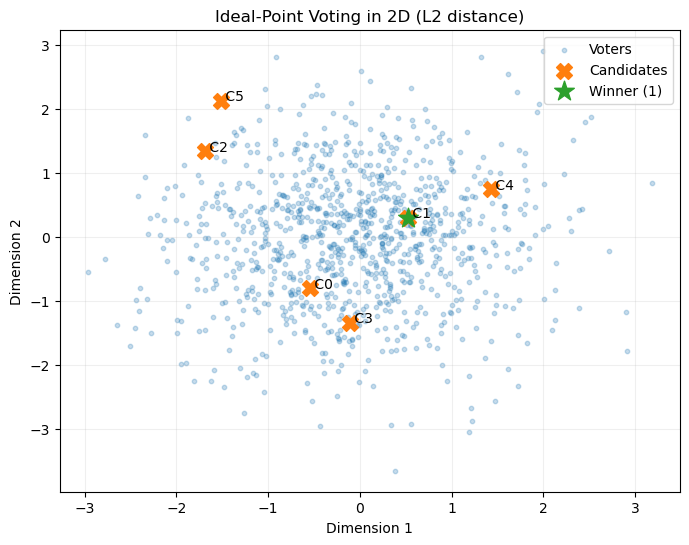

In [67]:
if d == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(voters[:, 0], voters[:, 1], s=10, alpha=0.25, label="Voters")
    plt.scatter(candidates[:, 0], candidates[:, 1], s=130, marker="X", label="Candidates")

    winner = result["winner"]
    plt.scatter(
        candidates[winner, 0],
        candidates[winner, 1],
        s=220,
        marker="*",
        label=f"Winner ({winner})",
    )

    for j in range(n_candidates):
        plt.text(candidates[j, 0], candidates[j, 1], f" C{j}", fontsize=10)

    plt.title(f"Ideal-Point Voting in {d}D (L{p_metric} distance)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()
else:
    print("Set d=2 to visualize voter and candidate positions.")

## Multiple Additional Instances

Run several fresh random instances and produce the same outputs for each one: plot, Borda table, average-utility table, win-rate table, and peeling Borda leaderboard.


=== Instance 1 ===
Borda winner: candidate 1
Average-utility winner: candidate 1


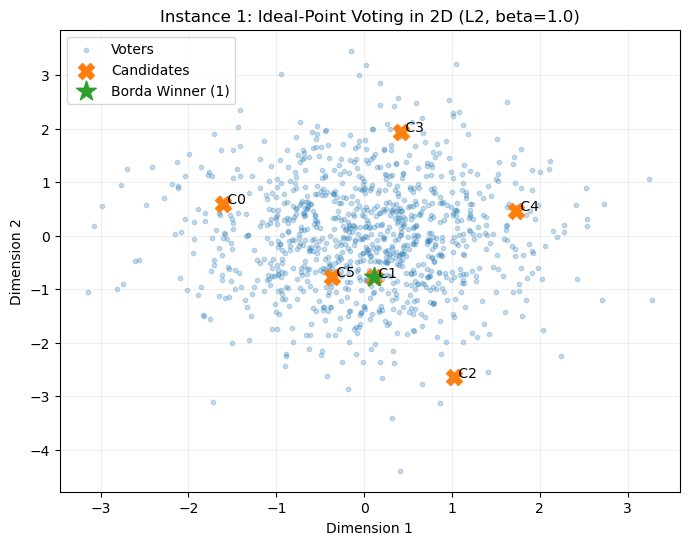

Borda scores and shares:


,candidate,borda_score,borda_share
0,1,3.740948,0.207830
1,5,3.681564,0.204531
2,4,2.948345,0.163797
3,0,2.944216,0.163568
4,3,2.742434,0.152357
5,2,1.942492,0.107916


Average utility per candidate:


,candidate,avg_utility
0,1,-1.435328
1,5,-1.475940
2,0,-2.070704
3,4,-2.093849
4,3,-2.260316
5,2,-3.002579


Pairwise win rates per candidate:


,candidate,win_rate
0,1,0.648190
1,5,0.636313
2,4,0.489669
3,0,0.488843
4,3,0.448487
5,2,0.288498


Peeling Borda leaderboard:


,rank,candidate,borda_score_at_pick,remaining_pool_size
0,1,1,3.740948,6
1,2,5,3.191607,5
2,3,4,2.206858,4
3,4,0,1.697465,3
4,5,3,1.120395,2
5,6,2,0.500000,1


Ranking comparison table:


,rank,avg_utility_candidate,borda_candidate,peeling_borda_candidate
0,1,1,1,1
1,2,5,5,5
2,3,0,4,4
3,4,4,0,0
4,5,3,3,3
5,6,2,2,2



=== Instance 2 ===
Borda winner: candidate 2
Average-utility winner: candidate 2


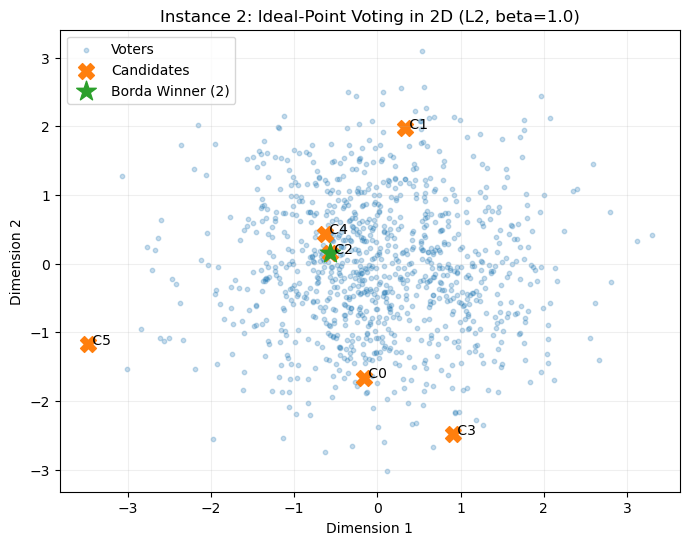

Borda scores and shares:


,candidate,borda_score,borda_share
0,2,3.986064,0.221448
1,4,3.885862,0.215881
2,0,3.345330,0.185852
3,1,2.885624,0.160312
4,3,2.436100,0.135339
5,5,1.461020,0.081168


Average utility per candidate:


,candidate,avg_utility
0,2,-1.366472
1,4,-1.444969
2,0,-1.961764
3,1,-2.305298
4,3,-2.786804
5,5,-3.818595


Pairwise win rates per candidate:


,candidate,win_rate
0,2,0.697213
1,4,0.677172
2,0,0.569066
3,1,0.477125
4,3,0.387220
5,5,0.192204


Peeling Borda leaderboard:


,rank,candidate,borda_score_at_pick,remaining_pool_size
0,1,2,3.986064,6
1,2,4,3.405387,5
2,3,0,2.574938,4
3,4,1,1.823900,3
4,5,3,1.183208,2
5,6,5,0.500000,1


Ranking comparison table:


,rank,avg_utility_candidate,borda_candidate,peeling_borda_candidate
0,1,2,2,2
1,2,4,4,4
2,3,0,0,0
3,4,1,1,1
4,5,3,3,3
5,6,5,5,5



=== Instance 3 ===
Borda winner: candidate 1
Average-utility winner: candidate 1


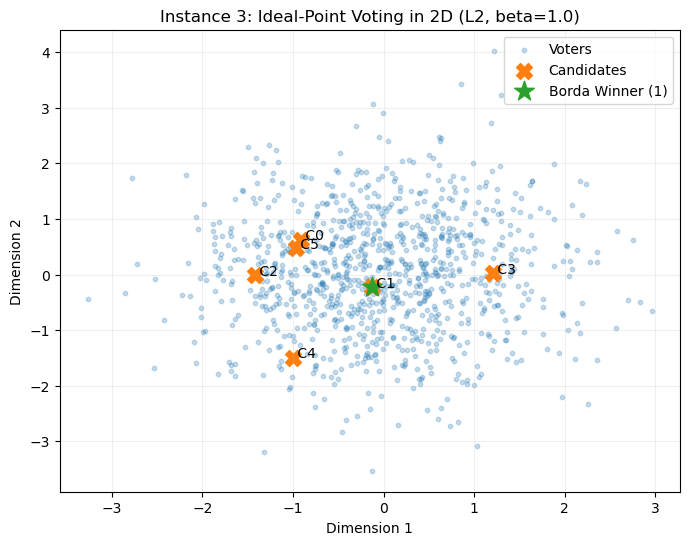

Borda scores and shares:


,candidate,borda_score,borda_share
0,1,3.524065,0.195781
1,5,3.130079,0.173893
2,0,3.110310,0.172795
3,3,2.930577,0.162810
4,2,2.841828,0.157879
5,4,2.463141,0.136841


Average utility per candidate:


,candidate,avg_utility
0,1,-1.298965
1,5,-1.583323
2,0,-1.596172
3,3,-1.731287
4,2,-1.798565
5,4,-2.108366


Pairwise win rates per candidate:


,candidate,win_rate
0,1,0.604813
1,5,0.526016
2,0,0.522062
3,3,0.486115
4,2,0.468366
5,4,0.392628


Peeling Borda leaderboard:


,rank,candidate,borda_score_at_pick,remaining_pool_size
0,1,1,3.524065,6
1,2,5,2.696467,5
2,3,0,2.182291,4
3,4,3,1.585197,3
4,5,2,1.070250,2
5,6,4,0.500000,1


Ranking comparison table:


,rank,avg_utility_candidate,borda_candidate,peeling_borda_candidate
0,1,1,1,1
1,2,5,5,5
2,3,0,0,0
3,4,3,3,3
4,5,2,2,2
5,6,4,4,4


In [68]:
from IPython.display import display

n_extra_instances = 3

for instance_idx in range(1, n_extra_instances + 1):
    voters_i = generate_ideal_points(n_voters, d, rng, distribution="normal", scale=1.0)
    candidates_i = generate_ideal_points(n_candidates, d, rng, distribution="normal", scale=1.2)

    borda_i = simulate_borda_from_distance(voters_i, candidates_i, p=p_metric, beta=beta)

    borda_summary_i = pd.DataFrame({
        "candidate": np.arange(n_candidates),
        "borda_score": borda_i["borda_scores"],
        "borda_share": borda_i["borda_shares"],
    }).sort_values("borda_score", ascending=False).reset_index(drop=True)

    avg_utility_i = borda_i["utilities"].mean(axis=0)
    utility_summary_i = pd.DataFrame({
        "candidate": np.arange(n_candidates),
        "avg_utility": avg_utility_i,
    }).sort_values("avg_utility", ascending=False).reset_index(drop=True)

    pairwise_mean_i = borda_i["pairwise_probs"].mean(axis=0)
    if n_candidates > 1:
        win_rates_i = (pairwise_mean_i.sum(axis=1) - 0.5) / (n_candidates - 1)
    else:
        win_rates_i = np.array([1.0])

    win_rate_table_i = pd.DataFrame({
        "candidate": np.arange(n_candidates),
        "win_rate": win_rates_i,
    }).sort_values("win_rate", ascending=False).reset_index(drop=True)

    remaining_i = list(range(n_candidates))
    leaderboard_rows_i = []
    for rank_i in range(1, n_candidates + 1):
        rem_candidates_i = candidates_i[remaining_i]
        rem_result_i = simulate_borda_from_distance(voters_i, rem_candidates_i, p=p_metric, beta=beta)
        local_winner_i = int(rem_result_i["winner"])
        global_winner_i = int(remaining_i[local_winner_i])
        leaderboard_rows_i.append({
            "rank": rank_i,
            "candidate": global_winner_i,
            "borda_score_at_pick": float(rem_result_i["borda_scores"][local_winner_i]),
            "remaining_pool_size": len(remaining_i),
        })
        remaining_i.pop(local_winner_i)
    borda_leaderboard_i = pd.DataFrame(leaderboard_rows_i)

    ranking_avg_utility_i = np.argsort(-avg_utility_i)
    ranking_borda_i = np.argsort(-borda_i["borda_scores"])
    ranking_peeling_i = borda_leaderboard_i["candidate"].to_numpy()
    rankings_table_i = pd.DataFrame({
        "rank": np.arange(1, n_candidates + 1),
        "avg_utility_candidate": ranking_avg_utility_i,
        "borda_candidate": ranking_borda_i,
        "peeling_borda_candidate": ranking_peeling_i,
    })

    print(f"\n=== Instance {instance_idx} ===")
    print(f"Borda winner: candidate {int(borda_i['winner'])}")
    print(f"Average-utility winner: candidate {int(avg_utility_i.argmax())}")

    if d == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(voters_i[:, 0], voters_i[:, 1], s=10, alpha=0.25, label="Voters")
        plt.scatter(candidates_i[:, 0], candidates_i[:, 1], s=130, marker="X", label="Candidates")
        winner_i = int(borda_i["winner"])
        plt.scatter(candidates_i[winner_i, 0], candidates_i[winner_i, 1], s=220, marker="*", label=f"Borda Winner ({winner_i})")
        for j in range(n_candidates):
            plt.text(candidates_i[j, 0], candidates_i[j, 1], f" C{j}", fontsize=10)
        plt.title(f"Instance {instance_idx}: Ideal-Point Voting in {d}D (L{p_metric}, beta={beta})")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.legend()
        plt.grid(alpha=0.2)
        plt.show()

    print("Borda scores and shares:")
    display(borda_summary_i)
    print("Average utility per candidate:")
    display(utility_summary_i)
    print("Pairwise win rates per candidate:")
    display(win_rate_table_i)
    print("Peeling Borda leaderboard:")
    display(borda_leaderboard_i)
    print("Ranking comparison table:")
    display(rankings_table_i)


## Partisan Voter Example

Construct a somewhat partisan electorate with two voter blocs (two nearby ideological centers), then run the same Borda/utility analysis tables.

=== Partisan Instance ===
Borda winner: candidate 1
Average-utility winner: candidate 1


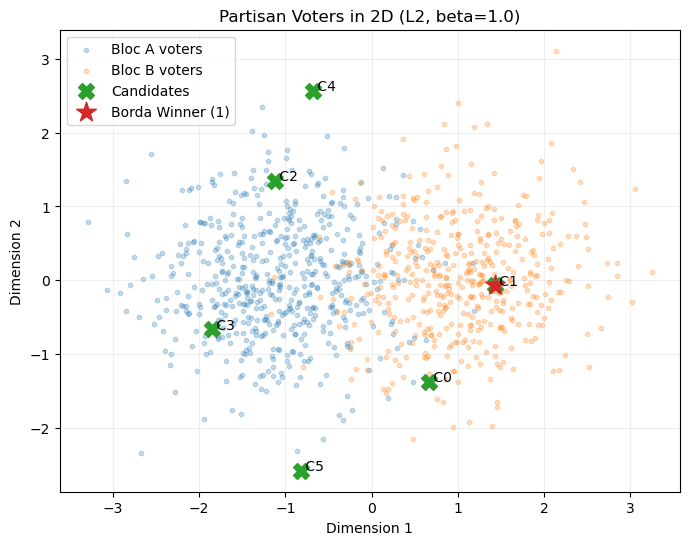

Borda scores and shares:


,candidate,borda_score,borda_share
0,1,3.417935,0.189885
1,2,3.350524,0.186140
2,0,3.338157,0.185453
3,3,3.279216,0.182179
4,4,2.333703,0.129650
5,5,2.280465,0.126693


Average utility per candidate:


,candidate,avg_utility
0,1,-1.903087
1,0,-2.039293
2,2,-2.058766
3,3,-2.096295
4,4,-2.918504
5,5,-2.958933


Pairwise win rates per candidate:


,candidate,win_rate
0,1,0.583587
1,2,0.570105
2,0,0.567631
3,3,0.555843
4,4,0.366741
5,5,0.356093


Peeling Borda leaderboard:


,rank,candidate,borda_score_at_pick,remaining_pool_size
0,1,1,3.417935,6
1,2,2,2.869571,5
2,3,0,2.361483,4
3,4,3,1.827034,3
4,5,4,1.006788,2
5,6,5,0.500000,1


Ranking comparison table:


,rank,avg_utility_candidate,borda_candidate,peeling_borda_candidate
0,1,1,1,1
1,2,0,2,2
2,3,2,0,0
3,4,3,3,3
4,5,4,4,4
5,6,5,5,5


In [69]:
from IPython.display import display

# Partisan electorate parameters
bloc_share = 0.55          # majority bloc share
partisan_separation = 2.2  # distance between bloc centers
within_bloc_scale = 0.75   # dispersion within each bloc

n_bloc_a = int(round(n_voters * bloc_share))
n_bloc_b = n_voters - n_bloc_a

center_a = np.zeros(d)
center_b = np.zeros(d)
center_a[0] = -partisan_separation / 2
center_b[0] = partisan_separation / 2

voters_a = rng.normal(loc=center_a, scale=within_bloc_scale, size=(n_bloc_a, d))
voters_b = rng.normal(loc=center_b, scale=within_bloc_scale, size=(n_bloc_b, d))
voters_partisan = np.vstack([voters_a, voters_b])
voter_bloc = np.array([0] * n_bloc_a + [1] * n_bloc_b)

# Candidates still sampled from a common pool
candidates_partisan = generate_ideal_points(n_candidates, d, rng, distribution="normal", scale=1.2)

partisan_result = simulate_borda_from_distance(voters_partisan, candidates_partisan, p=p_metric, beta=beta)

partisan_borda_summary = pd.DataFrame({
    "candidate": np.arange(n_candidates),
    "borda_score": partisan_result["borda_scores"],
    "borda_share": partisan_result["borda_shares"],
}).sort_values("borda_score", ascending=False).reset_index(drop=True)

partisan_avg_utility = partisan_result["utilities"].mean(axis=0)
partisan_utility_summary = pd.DataFrame({
    "candidate": np.arange(n_candidates),
    "avg_utility": partisan_avg_utility,
}).sort_values("avg_utility", ascending=False).reset_index(drop=True)

partisan_pairwise_mean = partisan_result["pairwise_probs"].mean(axis=0)
if n_candidates > 1:
    partisan_win_rates = (partisan_pairwise_mean.sum(axis=1) - 0.5) / (n_candidates - 1)
else:
    partisan_win_rates = np.array([1.0])

partisan_win_rate_table = pd.DataFrame({
    "candidate": np.arange(n_candidates),
    "win_rate": partisan_win_rates,
}).sort_values("win_rate", ascending=False).reset_index(drop=True)

remaining_p = list(range(n_candidates))
leaderboard_rows_p = []
for rank_p in range(1, n_candidates + 1):
    rem_candidates_p = candidates_partisan[remaining_p]
    rem_result_p = simulate_borda_from_distance(voters_partisan, rem_candidates_p, p=p_metric, beta=beta)
    local_winner_p = int(rem_result_p["winner"])
    global_winner_p = int(remaining_p[local_winner_p])
    leaderboard_rows_p.append({
        "rank": rank_p,
        "candidate": global_winner_p,
        "borda_score_at_pick": float(rem_result_p["borda_scores"][local_winner_p]),
        "remaining_pool_size": len(remaining_p),
    })
    remaining_p.pop(local_winner_p)
partisan_peeling_table = pd.DataFrame(leaderboard_rows_p)

partisan_rankings_table = pd.DataFrame({
    "rank": np.arange(1, n_candidates + 1),
    "avg_utility_candidate": np.argsort(-partisan_avg_utility),
    "borda_candidate": np.argsort(-partisan_result["borda_scores"]),
    "peeling_borda_candidate": partisan_peeling_table["candidate"].to_numpy(),
})

print("=== Partisan Instance ===")
print(f"Borda winner: candidate {int(partisan_result['winner'])}")
print(f"Average-utility winner: candidate {int(partisan_avg_utility.argmax())}")

if d == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(voters_partisan[voter_bloc == 0, 0], voters_partisan[voter_bloc == 0, 1], s=10, alpha=0.25, label="Bloc A voters")
    plt.scatter(voters_partisan[voter_bloc == 1, 0], voters_partisan[voter_bloc == 1, 1], s=10, alpha=0.25, label="Bloc B voters")
    plt.scatter(candidates_partisan[:, 0], candidates_partisan[:, 1], s=130, marker="X", label="Candidates")
    winner_p = int(partisan_result["winner"])
    plt.scatter(candidates_partisan[winner_p, 0], candidates_partisan[winner_p, 1], s=220, marker="*", label=f"Borda Winner ({winner_p})")
    for j in range(n_candidates):
        plt.text(candidates_partisan[j, 0], candidates_partisan[j, 1], f" C{j}", fontsize=10)
    plt.title(f"Partisan Voters in {d}D (L{p_metric}, beta={beta})")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

print("Borda scores and shares:")
display(partisan_borda_summary)
print("Average utility per candidate:")
display(partisan_utility_summary)
print("Pairwise win rates per candidate:")
display(partisan_win_rate_table)
print("Peeling Borda leaderboard:")
display(partisan_peeling_table)
print("Ranking comparison table:")
display(partisan_rankings_table)


### Partisan Example with Higher Sharpness (beta = 5)

Same partisan setup as above, but with a steeper pairwise sigmoid.

=== Partisan Instance (beta = 5) ===
Borda winner: candidate 2
Average-utility winner: candidate 1


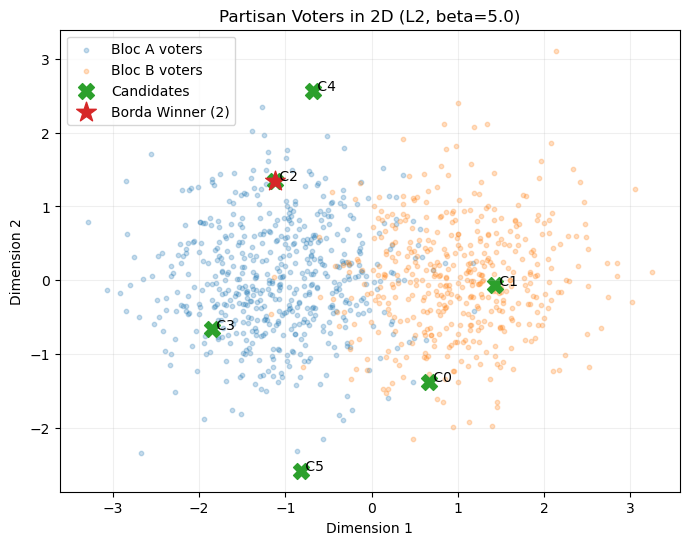

Borda scores and shares:


,candidate,borda_score,borda_share
0,2,3.737335,0.207630
1,0,3.560656,0.197814
2,1,3.485394,0.193633
3,3,3.441533,0.191196
4,4,1.903495,0.105750
5,5,1.871587,0.103977


Average utility per candidate:


,candidate,avg_utility
0,1,-1.903087
1,0,-2.039293
2,2,-2.058766
3,3,-2.096295
4,4,-2.918504
5,5,-2.958933


Pairwise win rates per candidate:


,candidate,win_rate
0,2,0.647467
1,0,0.612131
2,1,0.597079
3,3,0.588307
4,4,0.280699
5,5,0.274317


Peeling Borda leaderboard:


,rank,candidate,borda_score_at_pick,remaining_pool_size
0,1,2,3.737335,6
1,2,0,3.051258,5
2,3,3,2.510221,4
3,4,1,1.946175,3
4,5,4,1.007607,2
5,6,5,0.500000,1


Ranking comparison table:


,rank,avg_utility_candidate,borda_candidate,peeling_borda_candidate
0,1,1,2,2
1,2,0,0,0
2,3,2,1,3
3,4,3,3,1
4,5,4,4,4
5,6,5,5,5


In [70]:
from IPython.display import display

beta_high = 5.0

partisan_result_b5 = simulate_borda_from_distance(voters_partisan, candidates_partisan, p=p_metric, beta=beta_high)

partisan_borda_summary_b5 = pd.DataFrame({
    "candidate": np.arange(n_candidates),
    "borda_score": partisan_result_b5["borda_scores"],
    "borda_share": partisan_result_b5["borda_shares"],
}).sort_values("borda_score", ascending=False).reset_index(drop=True)

partisan_avg_utility_b5 = partisan_result_b5["utilities"].mean(axis=0)
partisan_utility_summary_b5 = pd.DataFrame({
    "candidate": np.arange(n_candidates),
    "avg_utility": partisan_avg_utility_b5,
}).sort_values("avg_utility", ascending=False).reset_index(drop=True)

partisan_pairwise_mean_b5 = partisan_result_b5["pairwise_probs"].mean(axis=0)
if n_candidates > 1:
    partisan_win_rates_b5 = (partisan_pairwise_mean_b5.sum(axis=1) - 0.5) / (n_candidates - 1)
else:
    partisan_win_rates_b5 = np.array([1.0])

partisan_win_rate_table_b5 = pd.DataFrame({
    "candidate": np.arange(n_candidates),
    "win_rate": partisan_win_rates_b5,
}).sort_values("win_rate", ascending=False).reset_index(drop=True)

remaining_p_b5 = list(range(n_candidates))
leaderboard_rows_p_b5 = []
for rank_p in range(1, n_candidates + 1):
    rem_candidates_p_b5 = candidates_partisan[remaining_p_b5]
    rem_result_p_b5 = simulate_borda_from_distance(voters_partisan, rem_candidates_p_b5, p=p_metric, beta=beta_high)
    local_winner_p_b5 = int(rem_result_p_b5["winner"])
    global_winner_p_b5 = int(remaining_p_b5[local_winner_p_b5])
    leaderboard_rows_p_b5.append({
        "rank": rank_p,
        "candidate": global_winner_p_b5,
        "borda_score_at_pick": float(rem_result_p_b5["borda_scores"][local_winner_p_b5]),
        "remaining_pool_size": len(remaining_p_b5),
    })
    remaining_p_b5.pop(local_winner_p_b5)
partisan_peeling_table_b5 = pd.DataFrame(leaderboard_rows_p_b5)

partisan_rankings_table_b5 = pd.DataFrame({
    "rank": np.arange(1, n_candidates + 1),
    "avg_utility_candidate": np.argsort(-partisan_avg_utility_b5),
    "borda_candidate": np.argsort(-partisan_result_b5["borda_scores"]),
    "peeling_borda_candidate": partisan_peeling_table_b5["candidate"].to_numpy(),
})

print("=== Partisan Instance (beta = 5) ===")
print(f"Borda winner: candidate {int(partisan_result_b5['winner'])}")
print(f"Average-utility winner: candidate {int(partisan_avg_utility_b5.argmax())}")

if d == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(voters_partisan[voter_bloc == 0, 0], voters_partisan[voter_bloc == 0, 1], s=10, alpha=0.25, label="Bloc A voters")
    plt.scatter(voters_partisan[voter_bloc == 1, 0], voters_partisan[voter_bloc == 1, 1], s=10, alpha=0.25, label="Bloc B voters")
    plt.scatter(candidates_partisan[:, 0], candidates_partisan[:, 1], s=130, marker="X", label="Candidates")
    winner_p_b5 = int(partisan_result_b5["winner"])
    plt.scatter(candidates_partisan[winner_p_b5, 0], candidates_partisan[winner_p_b5, 1], s=220, marker="*", label=f"Borda Winner ({winner_p_b5})")
    for j in range(n_candidates):
        plt.text(candidates_partisan[j, 0], candidates_partisan[j, 1], f" C{j}", fontsize=10)
    plt.title(f"Partisan Voters in {d}D (L{p_metric}, beta={beta_high})")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

print("Borda scores and shares:")
display(partisan_borda_summary_b5)
print("Average utility per candidate:")
display(partisan_utility_summary_b5)
print("Pairwise win rates per candidate:")
display(partisan_win_rate_table_b5)
print("Peeling Borda leaderboard:")
display(partisan_peeling_table_b5)
print("Ranking comparison table:")
display(partisan_rankings_table_b5)


## High-Agreement Voter Example

Construct an electorate where voters are tightly clustered in a small region of the space, then run the same Borda/utility analysis tables.

=== High-Agreement Instance ===
Borda winner: candidate 0
Average-utility winner: candidate 0


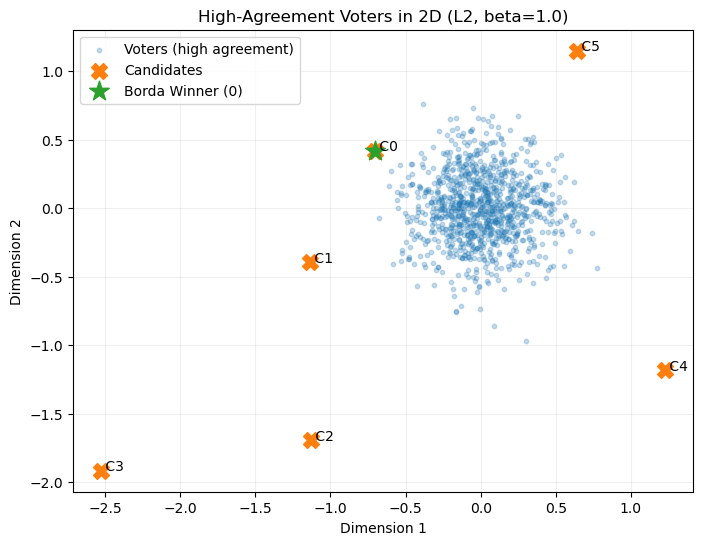

Borda scores and shares:


,candidate,borda_score,borda_share
0,0,4.072949,0.226275
1,1,3.617981,0.200999
2,5,3.467225,0.192624
3,4,2.982645,0.165703
4,2,2.556634,0.142035
5,3,1.302565,0.072365


Average utility per candidate:


,candidate,avg_utility
0,0,-0.856339
1,1,-1.231770
2,5,-1.338398
3,4,-1.722192
4,2,-2.052457
5,3,-3.181274


Pairwise win rates per candidate:


,candidate,win_rate
0,0,0.714590
1,1,0.623596
2,5,0.593445
3,4,0.496529
4,2,0.411327
5,3,0.160513


Peeling Borda leaderboard:


,rank,candidate,borda_score_at_pick,remaining_pool_size
0,1,0,4.072949,6
1,2,1,3.209818,5
2,3,5,2.608037,4
3,4,4,1.885157,3
4,5,2,1.255306,2
5,6,3,0.500000,1


Ranking comparison table:


,rank,avg_utility_candidate,borda_candidate,peeling_borda_candidate
0,1,0,0,0
1,2,1,1,1
2,3,5,5,5
3,4,4,4,4
4,5,2,2,2
5,6,3,3,3


In [71]:
from IPython.display import display

# High-agreement electorate parameters
agreement_center = np.zeros(d)
agreement_scale = 0.25  # tight clustering of voters

voters_agree = rng.normal(loc=agreement_center, scale=agreement_scale, size=(n_voters, d))
candidates_agree = generate_ideal_points(n_candidates, d, rng, distribution="normal", scale=1.2)

agree_result = simulate_borda_from_distance(voters_agree, candidates_agree, p=p_metric, beta=beta)

agree_borda_summary = pd.DataFrame({
    "candidate": np.arange(n_candidates),
    "borda_score": agree_result["borda_scores"],
    "borda_share": agree_result["borda_shares"],
}).sort_values("borda_score", ascending=False).reset_index(drop=True)

agree_avg_utility = agree_result["utilities"].mean(axis=0)
agree_utility_summary = pd.DataFrame({
    "candidate": np.arange(n_candidates),
    "avg_utility": agree_avg_utility,
}).sort_values("avg_utility", ascending=False).reset_index(drop=True)

agree_pairwise_mean = agree_result["pairwise_probs"].mean(axis=0)
if n_candidates > 1:
    agree_win_rates = (agree_pairwise_mean.sum(axis=1) - 0.5) / (n_candidates - 1)
else:
    agree_win_rates = np.array([1.0])

agree_win_rate_table = pd.DataFrame({
    "candidate": np.arange(n_candidates),
    "win_rate": agree_win_rates,
}).sort_values("win_rate", ascending=False).reset_index(drop=True)

remaining_a = list(range(n_candidates))
leaderboard_rows_a = []
for rank_a in range(1, n_candidates + 1):
    rem_candidates_a = candidates_agree[remaining_a]
    rem_result_a = simulate_borda_from_distance(voters_agree, rem_candidates_a, p=p_metric, beta=beta)
    local_winner_a = int(rem_result_a["winner"])
    global_winner_a = int(remaining_a[local_winner_a])
    leaderboard_rows_a.append({
        "rank": rank_a,
        "candidate": global_winner_a,
        "borda_score_at_pick": float(rem_result_a["borda_scores"][local_winner_a]),
        "remaining_pool_size": len(remaining_a),
    })
    remaining_a.pop(local_winner_a)
agree_peeling_table = pd.DataFrame(leaderboard_rows_a)

agree_rankings_table = pd.DataFrame({
    "rank": np.arange(1, n_candidates + 1),
    "avg_utility_candidate": np.argsort(-agree_avg_utility),
    "borda_candidate": np.argsort(-agree_result["borda_scores"]),
    "peeling_borda_candidate": agree_peeling_table["candidate"].to_numpy(),
})

print("=== High-Agreement Instance ===")
print(f"Borda winner: candidate {int(agree_result['winner'])}")
print(f"Average-utility winner: candidate {int(agree_avg_utility.argmax())}")

if d == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(voters_agree[:, 0], voters_agree[:, 1], s=10, alpha=0.25, label="Voters (high agreement)")
    plt.scatter(candidates_agree[:, 0], candidates_agree[:, 1], s=130, marker="X", label="Candidates")
    winner_a = int(agree_result["winner"])
    plt.scatter(candidates_agree[winner_a, 0], candidates_agree[winner_a, 1], s=220, marker="*", label=f"Borda Winner ({winner_a})")
    for j in range(n_candidates):
        plt.text(candidates_agree[j, 0], candidates_agree[j, 1], f" C{j}", fontsize=10)
    plt.title(f"High-Agreement Voters in {d}D (L{p_metric}, beta={beta})")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

print("Borda scores and shares:")
display(agree_borda_summary)
print("Average utility per candidate:")
display(agree_utility_summary)
print("Pairwise win rates per candidate:")
display(agree_win_rate_table)
print("Peeling Borda leaderboard:")
display(agree_peeling_table)
print("Ranking comparison table:")
display(agree_rankings_table)


## Optional extensions

- Add noise to utilities before choosing candidates.
- Replace plurality with ranked ballots (rank candidates by distance).
- Compare winners under different metrics ($L_1$, $L_2$, $L_\infty$).